In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/home/ubuntu/fastai/')
from fastai.imports import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

In [6]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [12]:
PATH = "/home/ubuntu/data/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [13]:
m = arch(True)

In [14]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [15]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [16]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [17]:
learn = ConvLearner.from_model_data(m, data)

In [18]:
learn.freeze_to(-4)

In [19]:
m[-1].trainable

True

In [20]:
m[-4].trainable

True

In [21]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.150769   0.112064   0.99      



[0.1120641677826643, 0.99]

In [22]:
learn.fit(0.01, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.107154   0.114067   0.9915    



[0.1140672824382782, 0.9915]

In [23]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [24]:
x,y = next(iter(data.val_dl))

In [25]:
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)

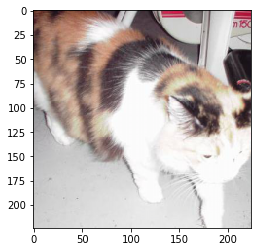

In [26]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [27]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [28]:
%time py = m(Variable(x.cuda()))

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.44 ms


In [29]:
for o in sfs: o.remove()

In [30]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [31]:
py = np.exp(to_np(py)[0]); py

array([1., 0.], dtype=float32)

In [32]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

In [33]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.00373, 0.16291, 0.36646, 0.462  , 0.37873, 0.20663, 0.0912 ],
       [0.     , 0.21646, 0.57521, 0.79069, 0.71915, 0.45984, 0.22562],
       [0.02312, 0.31304, 0.72809, 0.97684, 0.95263, 0.6994 , 0.4096 ],
       [0.05918, 0.33754, 0.69888, 0.9482 , 1.     , 0.85133, 0.56821],
       [0.05098, 0.24669, 0.50367, 0.7246 , 0.83076, 0.7764 , 0.54729],
       [0.01459, 0.1111 , 0.27631, 0.49385, 0.66625, 0.66063, 0.4605 ],
       [0.     , 0.     , 0.04053, 0.15795, 0.2934 , 0.31031, 0.20667]], dtype=float32)

NameError: name 'skimage' is not defined

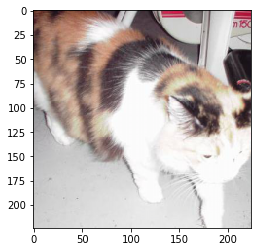

In [34]:
plt.imshow(dx)
plt.imshow(skimage.transform.resize(f2, dx.shape), alpha=0.5, cmap='hot');